In [1]:
import sys
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time

In [2]:
xs_train, ys_train = (
      torch.tensor([-3.5185,  4.7913, -5.7294,  6.8313, -6.1949, -2.8359,  3.5770, -9.7352,
               8.7236, -7.6444, -1.1604, -9.2950, -1.8292, -6.7322, -9.0877,  2.2723,
               2.7528,  5.6493, -5.1721,  7.4619,  2.5825,  6.7389, -3.8990, -5.9992,
              -4.8179, -0.1513,  6.4030, -1.3305, -2.6794, -9.2903, -6.6771,  9.1123,
              -6.6671, -5.1416, -6.7792,  6.6271,  2.0327, -2.4105,  0.2440,  7.1406]),
      torch.tensor([ -5.3765,  -9.0848,   2.1590,  -5.8315,   0.5031,  -3.8388,  -6.5292,
                9.6496,  -1.1439,   5.5176,  -8.8955,   4.3279,  -1.9723,   3.8308,
                6.4774,  -5.0248,  -7.7662,  -3.7932,  -1.8295,  -3.4870,  -6.7717,
               -4.3586,  -1.6717,   0.7881,  -0.4866,  -7.9941,  -8.7333,  -5.5161,
               -4.7155,   8.2325,  -1.7633,   2.4318,   1.8717,   1.8029,   2.2103,
               -4.0772,  -7.6173,  -3.6258, -10.3260,  -4.2308]))

xs_validation, ys_validation = (
      torch.tensor([-9.0973, -8.9917,  5.1596,  9.4471,  8.3714]),
      torch.tensor([ 8.7651,  5.7321, -5.7455, -0.1567, -3.6792]))

xs_test, ys_test = (
      torch.tensor([-9.9859, -1.1808, -3.3172,  7.6878,  7.2361]),
      torch.tensor([ 9.4506, -3.8572, -5.1936, -3.7723, -2.0726]))

In [3]:
from typing import Any


class MyCustomDataset(Dataset):
    def __init__(self, features, labels) -> None: #Features are in this case xs, and labels are ys.
        super().__init__()
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

class EarlyStopper():
    def __init__(self, patience=10) -> None:
        self.best_loss = None
        self.patience = patience
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter+=1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0
            self.best_loss = val_loss


In [4]:
train_data = MyCustomDataset(features=xs_train.view(-1,1), labels=ys_train.view(-1,1))
val_data = MyCustomDataset(features=xs_validation.view(-1,1), labels=ys_validation.view(-1,1))
test_data = MyCustomDataset(features=xs_test.view(-1,1), labels=ys_test.view(-1,1))

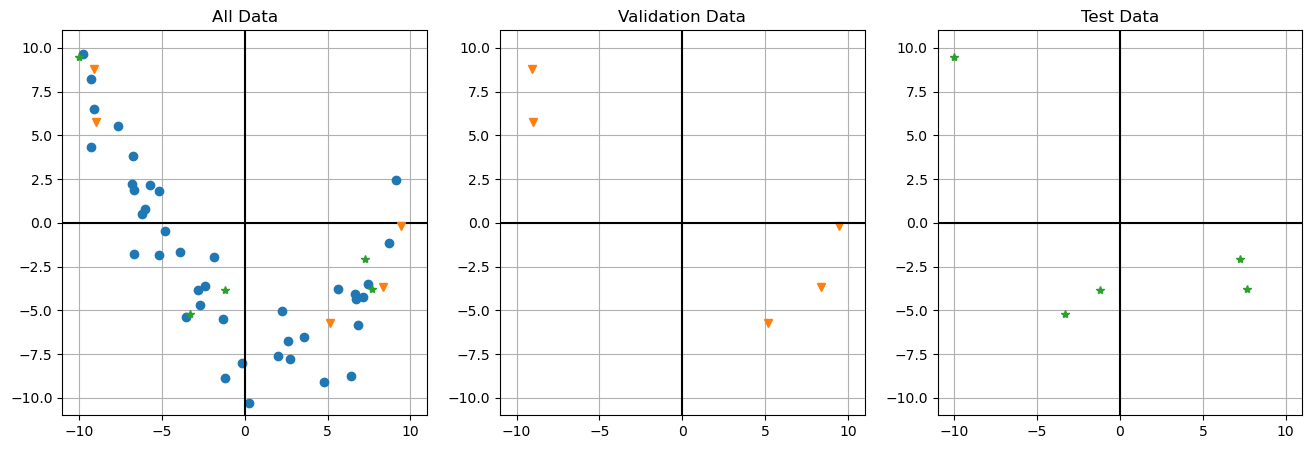

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
with torch.no_grad(): 
    for ax, dataset, symbol, color, title in zip(axs, [train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"], ["All Data","Validation Data", "Test Data"]):
        ax.plot(dataset.features, dataset.labels, symbol, color=color)
        ax.set_title(title)
        ax.grid()
        ax.set_xlim([-11,11])
        ax.set_ylim([-11,11])
        ax.hlines(0,-12,12, colors="k")
        ax.vlines(0,-12,12, colors="k")
axs[0].plot(val_data.features, val_data.labels, "v",color="C1")
axs[0].plot(test_data.features, test_data.labels, "*",color="C2")

In [6]:
class NNmodel(torch.nn.Module):
    def __init__(self, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.acc_func = activation_func
        self.hidden_layers = torch.nn.ParameterList()
        self.input_layer = torch.nn.Linear(1, dim_hiddens, bias=bias, dtype=torch.float)
        self.output_layer = torch.nn.Linear(dim_hiddens, 1, bias=bias, dtype=torch.float)
        for num in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(dim_hiddens, dim_hiddens, bias=bias, dtype=torch.float))

    def forward(self, x):
        x = self.acc_func(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.acc_func(layer(x))
        return self.output_layer(x)


def evaluate_total_loss(model, data_loader, loss_func):
    loss_val = torch.tensor([0.0])
    for x_dat, y_dat in data_loader:
        loss = loss_func(y_dat, model.forward(x_dat))
        loss_val+=loss*x_dat.size(0)
    return loss_val/len(data_loader.dataset)

def train_model(epochs, model, train_loader, val_loader, optimizer, test_loader=None, early_stopping=True, patience=10, loss_func=torch.nn.MSELoss()):
    early_stopper = EarlyStopper(patience=patience)
    train_losses = torch.zeros(epochs, 1)
    val_losses = torch.zeros(epochs, 1)
    for epoch in range(epochs):
        model.train()
        for x_dat, y_dat in train_loader: 
            optimizer.zero_grad()
            loss = loss_func(y_dat, model.forward(x_dat)) #Remember that the loss calculates a mean loss over all points in batch here.
            train_losses[epoch] += loss.item()*x_dat.size(0) 
            loss.backward()
            optimizer.step()
        
        train_losses[epoch]/=len(train_loader.dataset)
        
        model.eval()
        
        val_losses[epoch]+=evaluate_total_loss(model=model, data_loader=val_loader, loss_func=loss_func)
        
        if early_stopping == True:
            early_stopper(val_losses[epoch])
            if early_stopper.early_stop:
                break
    
    if test_loader is None:
        return train_losses[:epoch+1], val_losses[:epoch+1]
    else:
        test_loss = evaluate_total_loss(model=model, data_loader=test_loader, loss_func=loss_func)
        return train_losses[0:epoch], val_losses[0:epoch], test_loss[0:epoch]

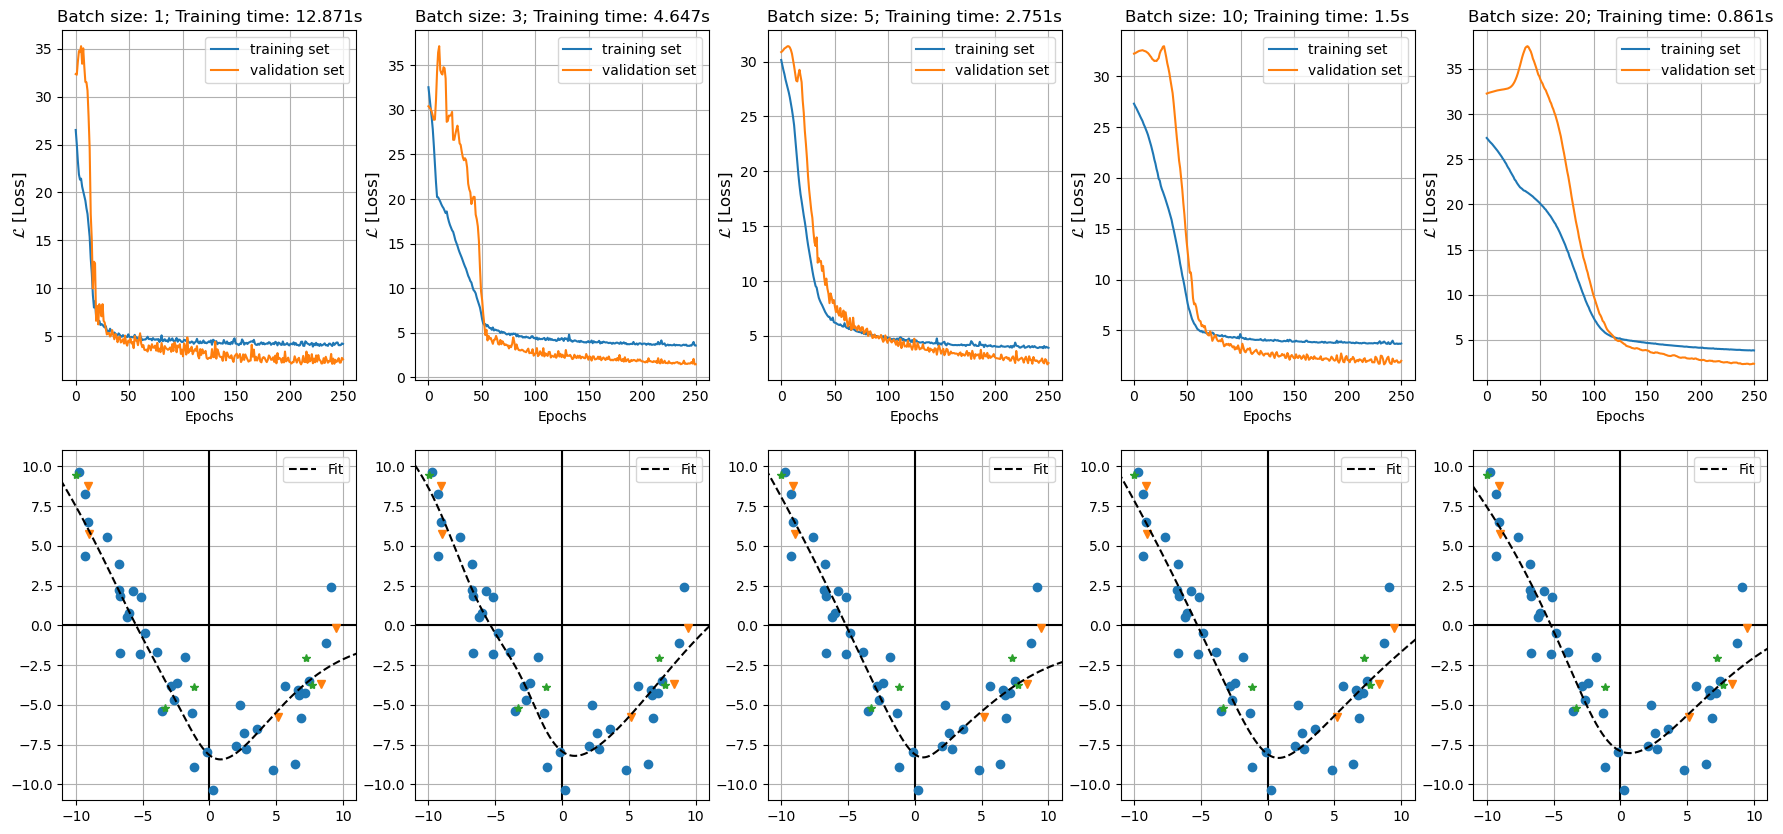

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(22,10))
epochs = 250
xs = torch.linspace(0, epochs, epochs)
xs_plot = torch.linspace(-12,12,1000)
for batch_size, ax1, ax2 in zip([1,3,5,10,20], axs[0], axs[1]):
    model = NNmodel(num_hidden_layers=3, dim_hiddens=12, activation_func=torch.nn.Softplus(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=5, shuffle=True)
    start = time.time()
    train_losses, val_losses = train_model(epochs=epochs, model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, early_stopping=False)
    end = time.time()
    ax1.grid()
    ax2.grid()
    ax1.set_ylabel(r"$\mathcal{L}$"+" [Loss]", fontsize=12)
    ax1.set_xlabel("Epochs")
    ax1.set_title(f"Batch size: {batch_size}; Training time: {round(end-start, 3)}s")
    ax2.set_xlim([-11,11])
    ax2.set_ylim([-11,11])
    with torch.no_grad():
        ax1.plot(xs.view(-1,1), train_losses, label="training set")
        ax1.plot(xs.view(-1,1), val_losses, label="validation set")
        ax2.hlines(0,-12,12, colors="k")
        ax2.vlines(0,-12,12, colors="k")
        for dataset, symbol, color in zip([train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"]):
            ax2.plot(dataset.features, dataset.labels, symbol, color=color)
        ax2.plot(xs_plot.view(-1,1), model.forward(xs_plot.view(-1,1)), c='k', ls="--", label="Fit")
    ax2.legend()
    ax1.legend()

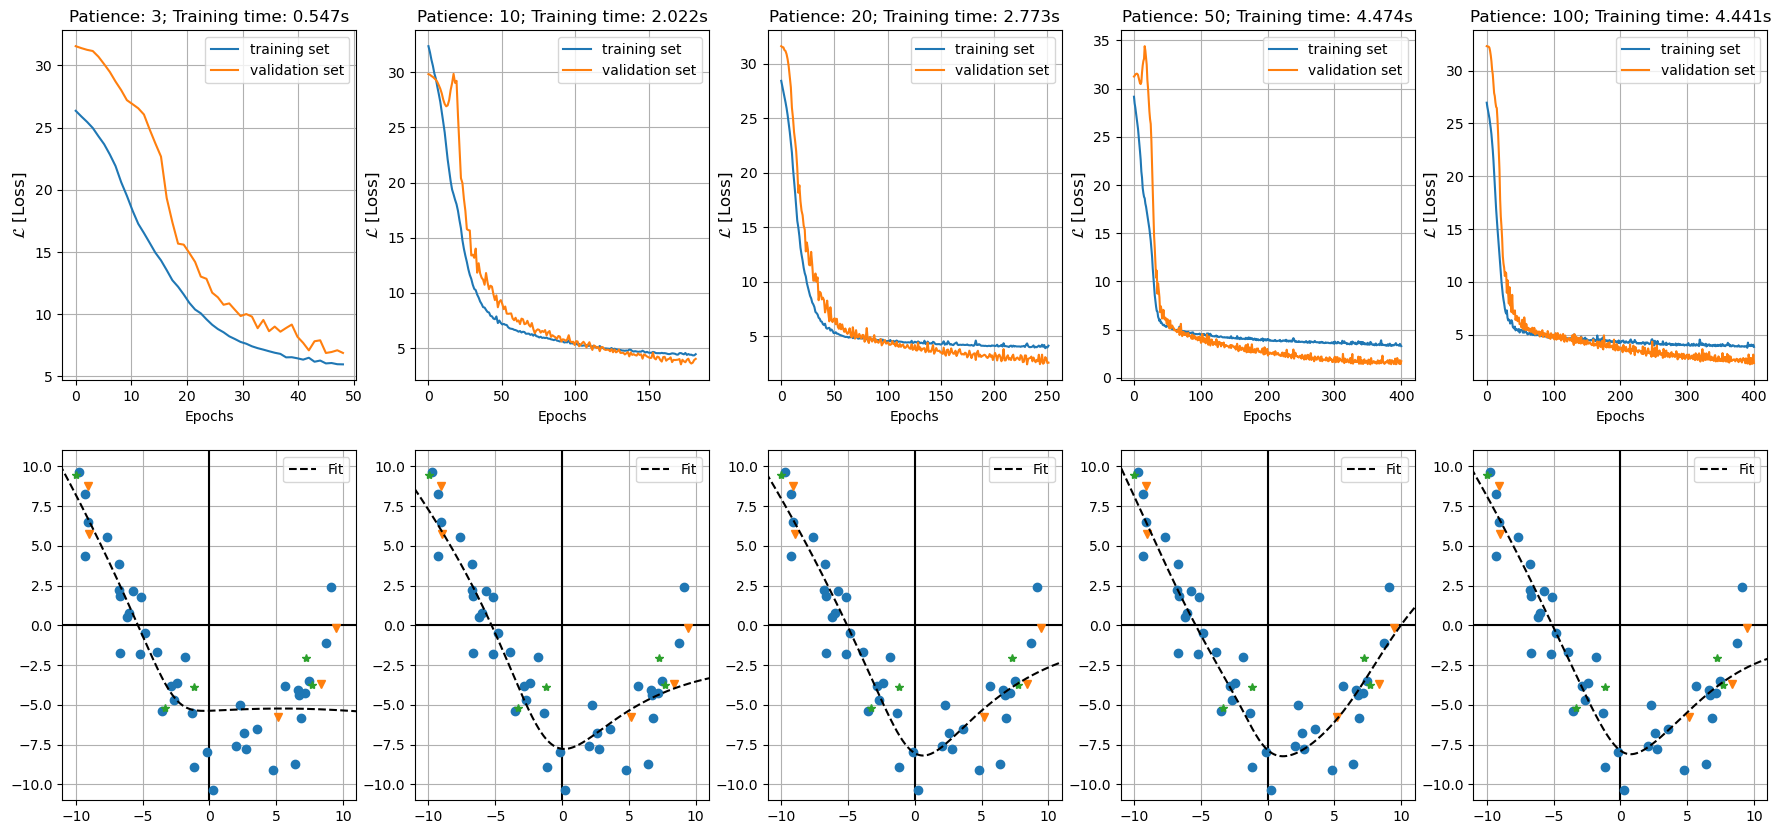

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(22,10))
epochs = 400
xs = torch.linspace(0, epochs, epochs)
xs_plot = torch.linspace(-12,12,1000)
for patience, ax1, ax2 in zip([3,10,20,50,100], axs[0], axs[1]):
    model = NNmodel(num_hidden_layers=3, dim_hiddens=12, activation_func=torch.nn.Softplus(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True) #WE USE BATCH SIZE OF 5
    val_loader = DataLoader(dataset=val_data, batch_size=5, shuffle=True)
    start = time.time()
    train_losses, val_losses = train_model(epochs=epochs, model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, early_stopping=True, patience=patience)
    end = time.time()
    xs = torch.linspace(0, len(train_losses), len(train_losses))
    ax1.grid()
    ax2.grid()
    ax1.set_ylabel(r"$\mathcal{L}$"+" [Loss]", fontsize=12)
    ax1.set_xlabel("Epochs")
    ax1.set_title(f"Patience: {patience}; Training time: {round(end-start, 3)}s")
    ax2.set_xlim([-11,11])
    ax2.set_ylim([-11,11])
    with torch.no_grad():
        ax1.plot(xs, train_losses, label="training set")
        ax1.plot(xs, val_losses, label="validation set")
        ax2.hlines(0,-12,12, colors="k")
        ax2.vlines(0,-12,12, colors="k")
        for dataset, symbol, color in zip([train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"]):
            ax2.plot(dataset.features, dataset.labels, symbol, color=color)
        ax2.plot(xs_plot.view(-1,1), model.forward(xs_plot.view(-1,1)), c='k', ls="--", label="Fit")
    ax2.legend()
    ax1.legend()

#Note here that the validation set, does not describe the tendency of our data vey well. Since this is the only contributor, to early-stopping
#We might still end up with odd fits.

In [9]:
def target_func(xs, offset=0.2, amplitude=0.5, freq=1.8):
    return abs(amplitude*np.sin(freq*xs)+offset)

xs_train = torch.rand(400)*3.0 - 1.5
xs_validation = torch.rand(50)*3.0 - 1.5
xs_test= torch.rand(50)*3.0 - 1.5

ys_train = target_func(xs_train) + torch.randn(len(xs_train))*0.1
ys_validation = target_func(xs_validation) + torch.randn(len(xs_validation))*0.1
ys_test = target_func(xs_test) + torch.randn(len(xs_test))*0.1
train_data = MyCustomDataset(features=xs_train.view(-1,1), labels=ys_train.view(-1,1))
val_data = MyCustomDataset(features=xs_validation.view(-1,1), labels=ys_validation.view(-1,1))
test_data = MyCustomDataset(features=xs_test.view(-1,1), labels=ys_test.view(-1,1))


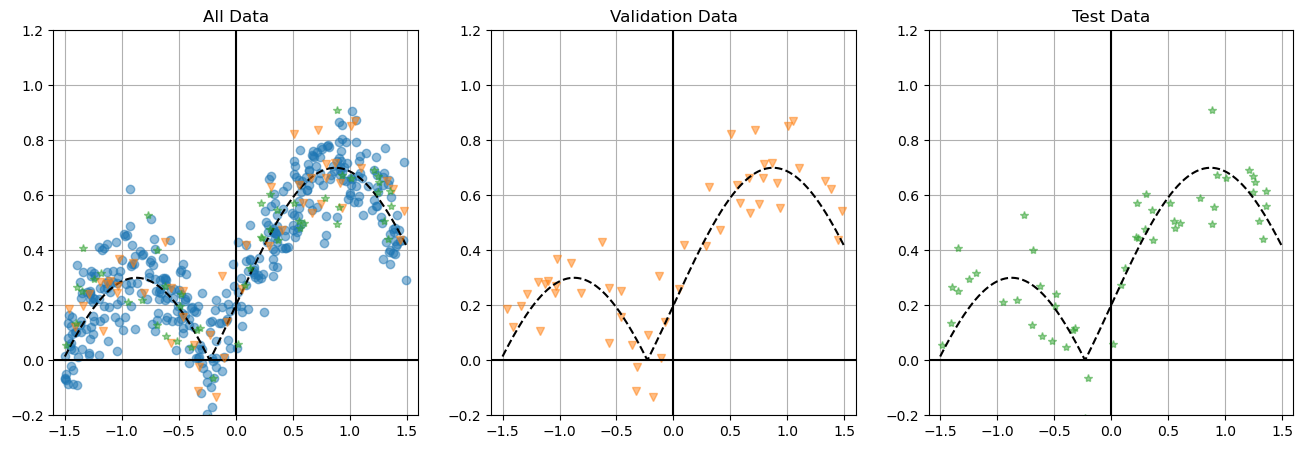

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
xs = np.linspace(-1.5,1.5, 1000)
with torch.no_grad(): 
    for ax, dataset, symbol, color, title in zip(axs, [train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"], ["All Data","Validation Data", "Test Data"]):
        ax.plot(dataset.features, dataset.labels, symbol, color=color, alpha=0.5)
        ax.set_title(title)
        ax.grid()
        ax.set_xlim([-1.6,1.6])
        ax.set_ylim([-0.2,1.2])
        ax.hlines(0,-12,12, colors="k")
        ax.vlines(0,-12,12, colors="k")
        ax.plot(xs, target_func(xs), c="k", ls="--")
axs[0].plot(val_data.features, val_data.labels, "v",color="C1", alpha=0.5)
axs[0].plot(test_data.features, test_data.labels, "*",color="C2", alpha=0.5)

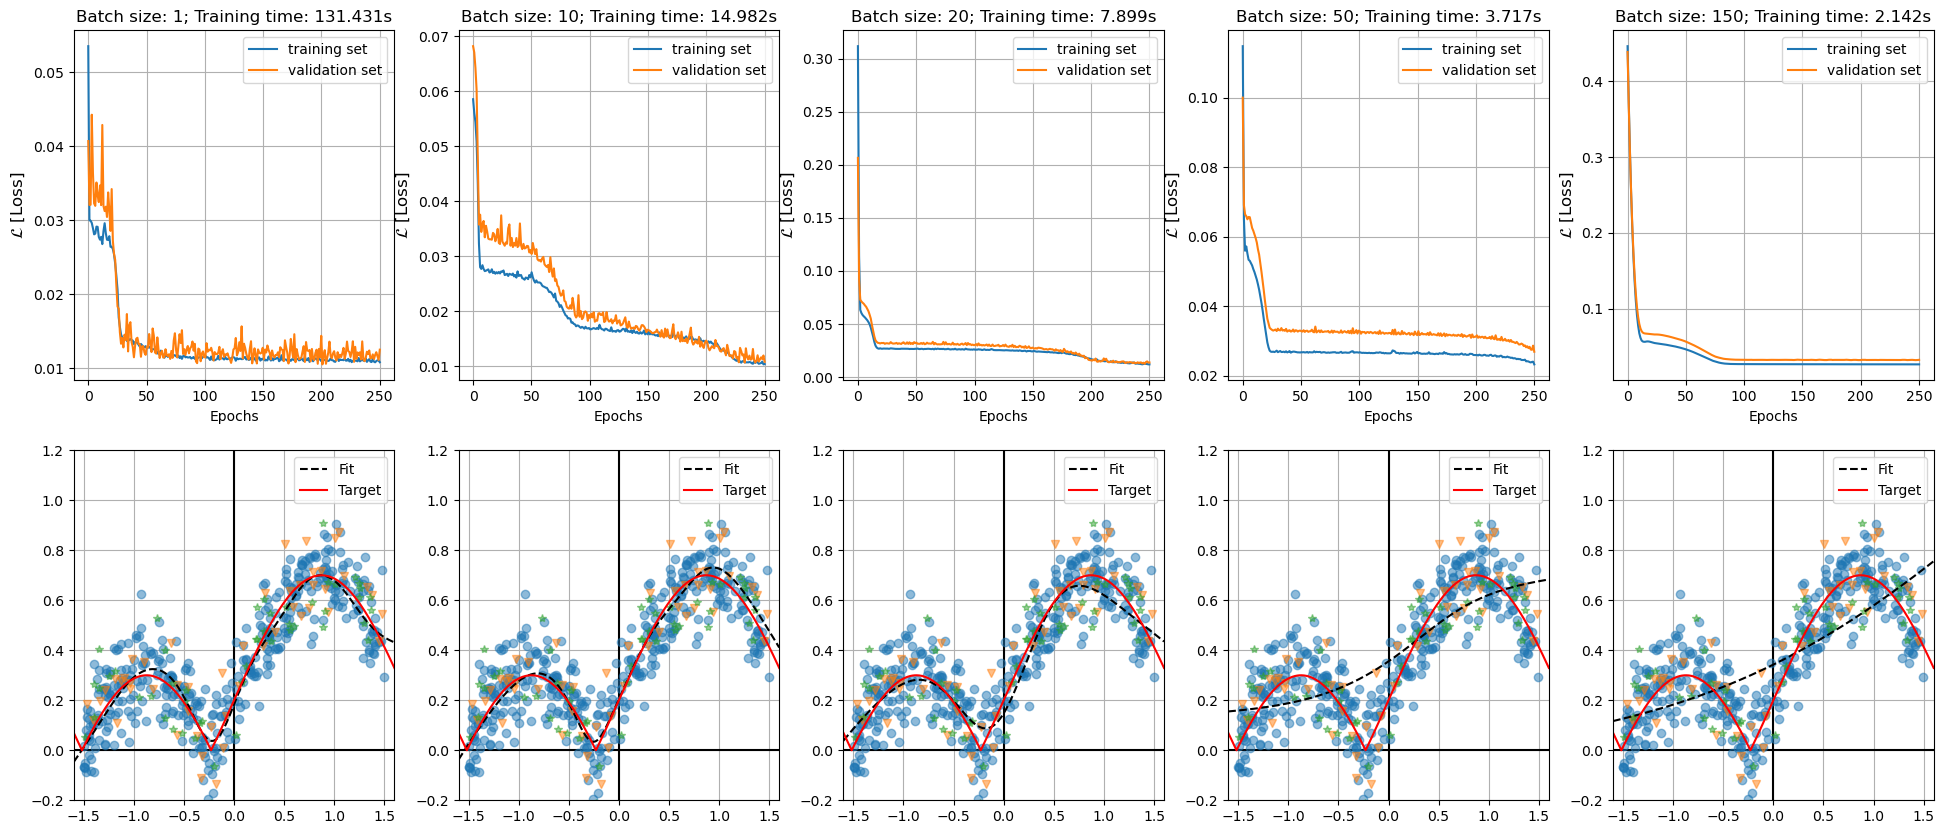

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(24,10))
epochs = 250
xs = torch.linspace(0, epochs, epochs)
xs_plot = torch.linspace(-1.6,1.6,1000)
for batch_size, ax1, ax2 in zip([1,10,20,50,150], axs[0], axs[1]):
    model = NNmodel(num_hidden_layers=3, dim_hiddens=12, activation_func=torch.nn.Softplus(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=50, shuffle=True)
    start = time.time()
    train_losses, val_losses = train_model(epochs=epochs, model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, early_stopping=False)
    end = time.time()
    ax1.grid()
    ax2.grid()
    ax1.set_ylabel(r"$\mathcal{L}$"+" [Loss]", fontsize=12)
    ax1.set_xlabel("Epochs")
    ax1.set_title(f"Batch size: {batch_size}; Training time: {round(end-start, 3)}s")
    ax2.set_xlim([-1.6,1.6])
    ax2.set_ylim([-0.2,1.2])
    with torch.no_grad():
        ax1.plot(xs.view(-1,1), train_losses, label="training set")
        ax1.plot(xs.view(-1,1), val_losses, label="validation set")
        ax2.hlines(0,-12,12, colors="k")
        ax2.vlines(0,-12,12, colors="k")
        for dataset, symbol, color in zip([train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"]):
            ax2.plot(dataset.features, dataset.labels, symbol, color=color, alpha=0.5)
        ax2.plot(xs_plot.view(-1,1), model.forward(xs_plot.view(-1,1)), c='k', ls="--", label="Fit")
        ax2.plot(xs_plot, target_func(xs_plot), c="r", label="Target")
    ax2.legend()
    ax1.legend()

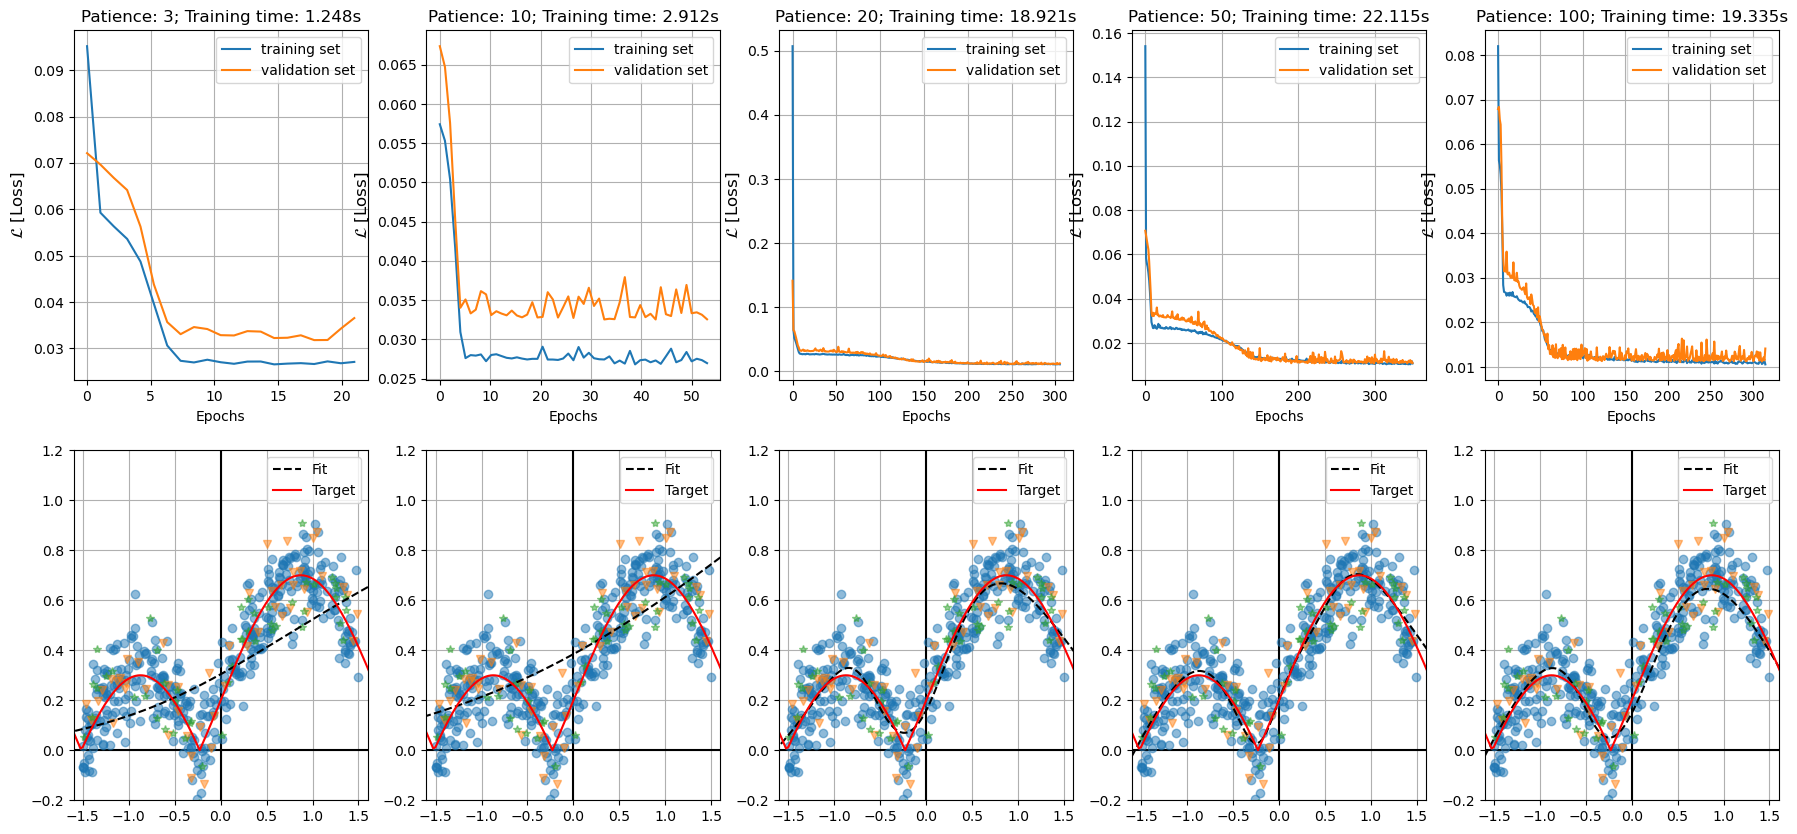

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(22,10))
epochs = 400
xs = torch.linspace(0, epochs, epochs)
xs_plot = torch.linspace(-12,12,1000)
for patience, ax1, ax2 in zip([3,10,20,50,100], axs[0], axs[1]):
    model = NNmodel(num_hidden_layers=3, dim_hiddens=12, activation_func=torch.nn.Softplus(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True) #WE USE BATCH SIZE OF 5
    val_loader = DataLoader(dataset=val_data, batch_size=50, shuffle=True)
    start = time.time()
    train_losses, val_losses = train_model(epochs=epochs, model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, early_stopping=True, patience=patience)
    end = time.time()
    xs = torch.linspace(0, len(train_losses), len(train_losses))
    ax1.grid()
    ax2.grid()
    ax1.set_ylabel(r"$\mathcal{L}$"+" [Loss]", fontsize=12)
    ax1.set_xlabel("Epochs")
    ax1.set_title(f"Patience: {patience}; Training time: {round(end-start, 3)}s")
    ax2.set_xlim([-1.6,1.6])
    ax2.set_ylim([-0.2,1.2])
    with torch.no_grad():
        ax1.plot(xs.view(-1,1), train_losses, label="training set")
        ax1.plot(xs.view(-1,1), val_losses, label="validation set")
        ax2.hlines(0,-12,12, colors="k")
        ax2.vlines(0,-12,12, colors="k")
        for dataset, symbol, color in zip([train_data, val_data, test_data], ["o", "v", "*"], ["C0", "C1", "C2"]):
            ax2.plot(dataset.features, dataset.labels, symbol, color=color, alpha=0.5)
        ax2.plot(xs_plot.view(-1,1), model.forward(xs_plot.view(-1,1)), c='k', ls="--", label="Fit")
        ax2.plot(xs_plot, target_func(xs_plot), c="r", label="Target")
    ax2.legend()
    ax1.legend()